In [1]:
import numpy as np
import scipy.stats as sstats
import RNG.Distributions as rngd
import matplotlib.pyplot as plt
import EventByEvent.DiscreteSim as ds
import EventByEvent.VarianceReduction as vr

### Exercise 5 Task 1):

We use the Crude Monte Carlo method on 100 samples and get a value of approx. 1.69-1.7

We are able to get means far away from the true mean 1.718....

In [2]:
U1 = np.random.uniform(0,1,100)
X = np.exp(U1)
print(np.mean(X))

1.7773355297811546


### Exercise 5 Task 2)

All of the means we've observed have the first three numbers of 1.71

In [3]:
X_prime = np.exp(1-U1)
Y = (X+X_prime)/2
print(np.mean(Y))

1.7164558721159795


### Exercise 5 Task 3)


We have a Y whose mean we know, and we would like to be able to estimate the mean of X, which we do not.

We set $Z = X + c \times (Y - \mu_{y})$, such that $E[Z] = E[X] + C*(0) = E[X]$

But we choose a c, to minimize the variance of Z:

$Var[Z] = Var[X] + c^{2}Var[Y] + 2cCov(X,y)$

Which gives us

$c = \frac{Cov(x,y)}{Var[Y]}$ which in total gives us that the variance of Z to be:

$Var[Z] = Var[X] - \frac{Cov(x,y)^2}{Var[Y]} \leq Var[X]$

Where $Y ~ U(0,1)$ in our case


In [4]:
c = -1*np.cov(X,U1)[1,0]/np.var(U1)
Z = X + c*(U1 - 1/2)
print(np.mean(Z))

1.714898976441456


Exercise 5 Task 4)


In [5]:
Wi = np.zeros(10)
for i in range(10):
    Wi += np.exp(i/10+ U1[i*10:(i+1)*10]/10)
Wi /= 10
print(Wi.mean())

1.7219188572718025


Exercise 5 Task 5)

We use the assumption that our proportions follow a standard normal distribution to do control variate method directly on these.

We let $Z = X + c(\bar{Y} -\mu_{Y})$

Here X = proportion of blocked customers and $\bar{Y}$  is the empirical mean arrival time.

We have that $mu_{\bar{Y}} = E[\bar{Y}] = E[Y]$ for large numbers of samples due to the law of large numbers.
An assumption here is of course that the different runs are independent.



Blocked C.I: [0.11360897033014489, 0.12065102966985511]	 Nr accepted in first run: 8776


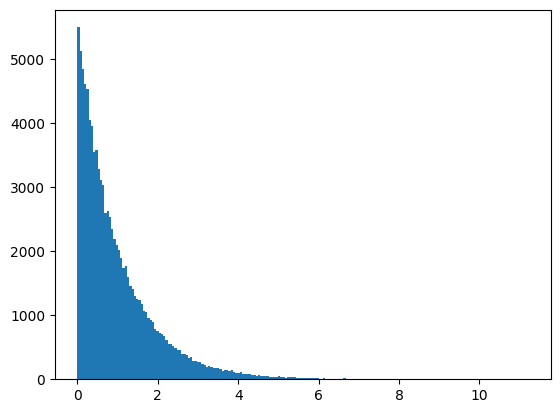

In [15]:
nrExperiments = 10
subSamples = []
m = 10
lambda_S = 1/8 #Time between services
lambda_A = 1 #Time between arrivals
k_S = 2.00

S_t = rngd.Exponential(lambda_S)
A_t = rngd.Exponential(lambda_A)

arrival_sample_for_plot = A_t.getSample(100000)
plt.hist(arrival_sample_for_plot,bins=200)
print("")

Y = []

for i in range(nrExperiments):


    servers = ds.BlockingServers(S_t,m)

    nrArrivals = 10*1000

    t = 0
    event_list = []
    Y_i = []
    for i in range(nrArrivals):
        sample_time = A_t.getSample()[0]
        t += sample_time
        Y_i += [sample_time]
        event_list += [t]

    blockingCounter = []

    for t_A in event_list:
        blockingCounter += [(t_A,servers.scheduleService(t_A))]

    subSamples += [blockingCounter]
    Y += [Y_i]


proportions = ds.getSubProportions(subSamples)
Z = []

for i,Yi in enumerate(Y):
    Z += vr.controlVariable(proportions[i],np.mean(Yi),lambda_A)


CI = ds.getConfidenceInterval(proportions)

print(f"Blocked C.I: {CI}\t Nr accepted in first run: {ds.getNrBlocked(subSamples[0]).count(0)}")